# Scenario 3: Causal Reasoning with Interventions

### Load dependencies

In [1]:
import os
import json
import sympy
import pandas as pd
import pyciemss
import torch
import pyro
import pyro.distributions as dist

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from mira.metamodel import *
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.metamodel.io import model_to_json_file, model_from_json_file
from pathlib import Path

## Simulate SEIR model

,timepoint_id,sample_id,timepoint_unknown,persistent_C_0_param,persistent_N_param,persistent_beta_param,persistent_mc_param,persistent_me_param,persistent_C_1_param,persistent_C_2_param,...,E_3_state,I_1_state,I_2_state,I_3_state,R_1_state,R_2_state,R_3_state,S_1_state,S_2_state,S_3_state
0,0,0,1.0,38.096661,39404740.0,0.433328,0.969919,0.001742,21.205523,6.348045,...,313.312042,65.535645,71.462509,60.705448,3.321655,3.438913,3.226434,10305241.0,15281325.0,12154159.0
1,1,0,2.0,38.096661,39404740.0,0.433328,0.969919,0.001742,21.205523,6.348045,...,707.782227,117.271027,144.041321,94.915070,8.587154,9.592317,7.758034,10304568.0,15280367.0,12153731.0
2,2,0,3.0,38.096661,39404740.0,0.433328,0.969919,0.001742,21.205523,6.348045,...,1442.971680,232.916748,307.425598,168.641525,18.671999,22.535339,15.411179,10303234.0,15278475.0,12152914.0
3,3,0,4.0,38.096661,39404740.0,0.433328,0.969919,0.001742,21.205523,6.348045,...,2909.930908,476.659821,653.344177,318.983246,39.098660,50.129135,29.533327,10300501.0,15274581.0,12151281.0
4,4,0,5.0,38.096661,39404740.0,0.433328,0.969919,0.001742,21.205523,6.348045,...,5898.517578,984.571228,1375.966431,624.210876,81.153465,108.464699,56.794651,10294836.0,15266504.0,12147962.0


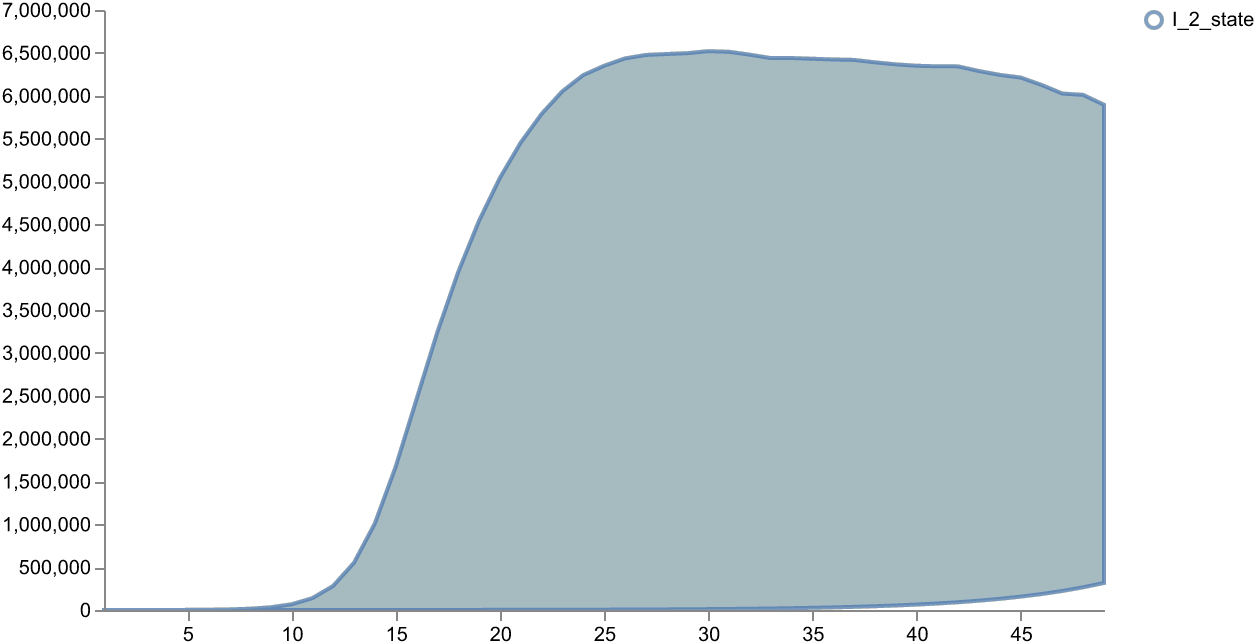

In [7]:
model1 = "S3_model_Pascale_updated.json"
start_time = 0.0
end_time = 50.0
logging_step_size = 1.0
num_samples = 100

result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time,
                        #   solver_method="rk4", solver_options={"step_size": 1.},
                          )
display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep="I_2_state")
# plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Calibrate the model 

Data wrangling

In [12]:
dataset_20 = pd.read_csv("data_cut_at_20.csv")
dataset_20 = dataset_20.drop(
    ["run", "R1", "R2", "R3", "S1", "S2", "S3", "E1", "E2", "E3"], axis=1
)
display(dataset_20)

,Timestamp,I1,I2,I3
0,0,50.000000,50.000000,50.000000
1,1,54.941877,56.474173,53.622694
2,2,67.851795,74.023679,62.493990
3,3,89.876683,104.270136,77.221285
4,4,123.568640,150.803945,99.234839
5,5,173.136310,219.533582,130.923536
6,6,244.945417,319.382809,175.911931
7,7,348.321181,463.408976,239.507686
8,8,496.748783,670.476206,329.372924
9,9,709.624122,967.695366,456.504595


Calibration

In [14]:
num_iterations = 100
data_mapping = {"I1": "I_1", "I2": "I_2", "I3": "I_3"}
# %time
calibrated_results = pyciemss.calibrate(
    model1,
    dataset_20,
    data_mapping=data_mapping,
    num_iterations=num_iterations,
)

parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\integration_utils\observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 20 rows of data. The first column, Timestamp, begins at 0 and ends at 20. The subsequent columns are named: I1, I2, I3


{'persistent_C_0': tensor(37.7128, grad_fn=<ExpandBackward0>),
 'persistent_N': tensor(38592804., grad_fn=<ExpandBackward0>),
 'persistent_beta': tensor(0.1293, grad_fn=<ExpandBackward0>),
 'persistent_mc': tensor(0.9762, grad_fn=<ExpandBackward0>),
 'persistent_me': tensor(0.0061, grad_fn=<ExpandBackward0>),
 'persistent_C_1': tensor(19.7045, grad_fn=<ExpandBackward0>),
 'persistent_C_2': tensor(6.2728, grad_fn=<ExpandBackward0>),
 'persistent_C_3': tensor(27.2118, grad_fn=<ExpandBackward0>),
 'persistent_C_4': tensor(20.0100, grad_fn=<ExpandBackward0>),
 'persistent_C_5': tensor(11.2192, grad_fn=<ExpandBackward0>),
 'persistent_C_6': tensor(19.5185, grad_fn=<ExpandBackward0>),
 'persistent_C_7': tensor(5.9272, grad_fn=<ExpandBackward0>),
 'persistent_C_8': tensor(11.2439, grad_fn=<ExpandBackward0>),
 'persistent_i': tensor(0.0777, grad_fn=<ExpandBackward0>),
 'persistent_r': tensor(0.0623, grad_fn=<ExpandBackward0>)}

,timepoint_id,sample_id,timepoint_unknown,persistent_C_0_param,persistent_N_param,persistent_beta_param,persistent_mc_param,persistent_me_param,persistent_C_1_param,persistent_C_2_param,...,E_3_state,I_1_state,I_2_state,I_3_state,R_1_state,R_2_state,R_3_state,S_1_state,S_2_state,S_3_state
0,0,0,1.0,38.413422,38628456.0,0.127978,0.978682,0.006022,19.786869,5.846016,...,119.571747,54.870651,56.332741,53.537613,3.065918,3.094877,3.039546,10305547.0,15281752.0,12154368.0
1,1,0,2.0,38.413422,38628456.0,0.127978,0.978682,0.006022,19.786869,5.846016,...,195.743347,67.720428,73.609276,62.305473,6.654112,6.885416,6.442375,10305414.0,15281571.0,12154280.0
2,2,0,3.0,38.413422,38628456.0,0.127978,0.978682,0.006022,19.786869,5.846016,...,289.093353,89.689819,103.418457,76.899696,11.264138,12.057427,10.531934,10305243.0,15281336.0,12154169.0
3,3,0,4.0,38.413422,38628456.0,0.127978,0.978682,0.006022,19.786869,5.846016,...,411.687256,123.314941,149.275940,98.725494,17.503735,19.446993,15.690582,10305001.0,15281007.0,12154019.0
4,4,0,5.0,38.413422,38628456.0,0.127978,0.978682,0.006022,19.786869,5.846016,...,578.856995,172.775620,216.965363,130.130447,26.177670,30.162949,22.410809,10304669.0,15280546.0,12153811.0


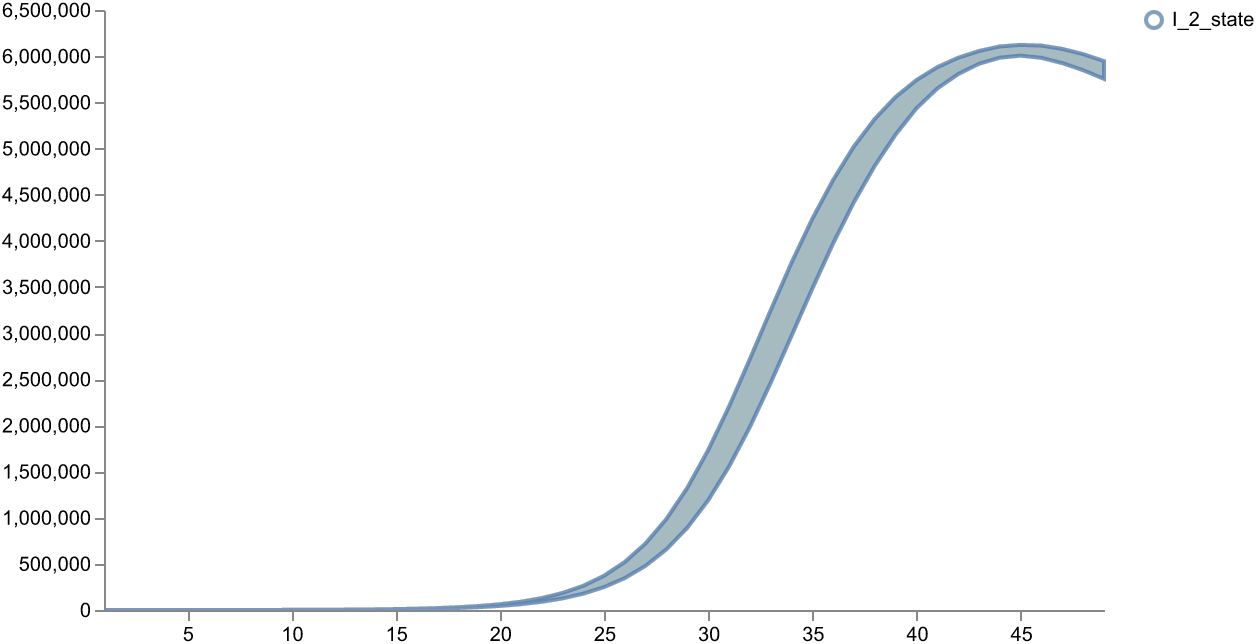

In [18]:
result_cal = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time,
                             inferred_parameters=parameter_estimates,
                          )
display(result_cal['data'].head())

# Plot results for all states
schema = plots.trajectories(result_cal["data"], keep="I_2_state")
# plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Optimization

In [19]:
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)
from pyciemss.ouu.qoi import obs_max_qoi, obs_nday_average_qoi

start_time = 0.0
end_time = 50.0
logging_step_size = 1.0
num_samples = 100
num_samples_ouu = 100
maxiter = 2
maxfeval = 25

In [22]:
# Define optimization problem setup
observed_params = ["I_2_state"]
intervened_params = ["me"]
initial_guess_interventions = 10.
bounds_interventions = [[0.0], [50.]]    # bounds should be withing start_time and end_time
intervention_value = torch.tensor([0.6])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 5e6
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -x

# Run optimize interface
opt_result2 = pyciemss.optimize(
    model1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    inferred_parameters=parameter_estimates,
    # solver_method="rk4",
    # solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)
print("Intervention: ", static_parameter_interventions(opt_result2["policy"]))

 44%|████▍     | 33/75 [17:25<22:10, 31.67s/it] 

Optimal policy: tensor([14.2464], dtype=torch.float64)
{'policy': tensor([14.2464], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: -14.246338529901404
                          x: [ 1.425e+01]
                        nit: 2
      minimization_failures: 3
                       nfev: 33
 lowest_optimization_result: message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
                             success: False
                              status: 4
                                 fun: -14.246338529901404
                                   x: [ 1.425e+01]
                                nfev: 11
                               maxcv: 0.8999999994412065}
Intervention:  {14.2464: {'me': tensor(0.6000)}}



C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\interfaces.py:950: UserWarning: Optimal intervention policy does not satisfy constraints.Check if the risk_bounds value is appropriate for given problem.Otherwise, try (i) different initial_guess_interventions, (ii) increasing maxiter/maxfeval,and/or (iii) increase n_samples_ouu to improve accuracy of Monte Carlo risk estimation. 
  warnings.warn(


Intervention:  {14.2464: {'me': tensor(0.6000)}}
Risk associated with QoI: [4946469.899999999]


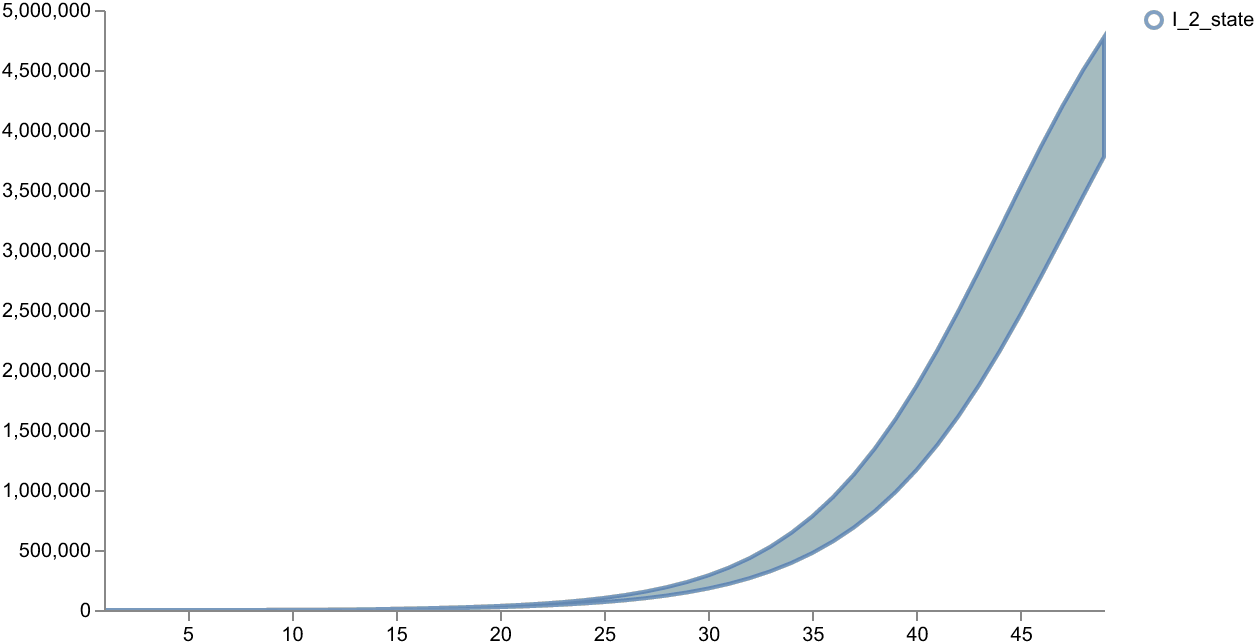

In [23]:
print("Intervention: ", static_parameter_interventions(opt_result2["policy"]))
with pyro.poutine.seed(rng_seed=0):
   result_opt = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time,
                              static_parameter_interventions=static_parameter_interventions(opt_result2["policy"]),
                              inferred_parameters=parameter_estimates,
                           )
# Check risk estimate used in constraints
print("Risk associated with QoI:", result_opt["risk"][observed_params[0]]["risk"])

# Plot results for all states
schema = plots.trajectories(result_opt["data"], keep="I_2_state")
# plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)